### Install dependencies

In [1]:
pip install scikit-learn scikit-image prettytable seaborn --quiet

Note: you may need to restart the kernel to use updated packages.


### Import libraries

In [2]:
import os
import PIL
import numpy as np
import random
import pickle
import seaborn as sns
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

from skimage.transform import resize
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict, learning_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.dummy import DummyClassifier

### Load dataset 

In [3]:
## Re-run EDA.ipynb if issues with loading pickle ##
# Load the pickled dataset (12335 augmented images; 128x128 pixels; binary labels - Fresh/Rotten; 80:20 train/test split)
X_train, X_test, y_train, y_test = pd.read_pickle(open("data_binary_128_split.pkl", "rb"))

### Data preprocessing

In [4]:
# Flatten images into 1D arrays
X_train_flat = []
for image in X_train:
    image_flattened = image.flatten()
    X_train_flat.append(image_flattened)
X_train_flat = np.array(X_train_flat)

# Repeat the same process for the test set
X_test_flat = []
for image in X_test:
    image_flattened = image.flatten()
    X_test_flat.append(image_flattened)
X_test_flat = np.array(X_test_flat)

### Build and train the Random Forest classifier using grid search for hyperparameter tuning

In [5]:
# Define the parameter grid for the Random Forest
param_grid = {
    'n_estimators': [500, 800, 1500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['log2']
}

# Create a Random Forest classifier
rf = RandomForestClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, verbose = 2, n_jobs = -1)

# Fit the GridSearchCV object to the training data
%time grid_search.fit(X_train_flat, y_train)

# Print the best parameters and the corresponding mean cross-validated score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_) 

Fitting 5 folds for each of 27 candidates, totalling 135 fits
CPU times: user 1min 20s, sys: 3.09 s, total: 1min 24s
Wall time: 8min 56s
Best parameters: {'max_depth': 30, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 800}
Best score: 0.9296704600249261


### Predict and evaluate performance on the train set (in-sample)

#### Predict on the train set (5-fold cross validation)

In [6]:
# Perform 5-fold cross-validation on the rf model to get predictions made on each fold
best_model_train = grid_search.best_estimator_
y_train_pred = cross_val_predict(best_model_train, X_train_flat, y_train, cv = 5, method='predict')
y_train_pred_prob = cross_val_predict(best_model_train, X_train_flat, y_train, cv = 5, method='predict_proba')

In [7]:
# perform cross validation to check if model is overfitting 
y_scores = cross_val_score(best_model_train, X_train_flat, y_train, cv = 5)
print(f'Cross-validated scores: {y_scores}')

Cross-validated scores: [0.94275583 0.92907801 0.93414387 0.92042575 0.92397364]


#### Model evaluation 

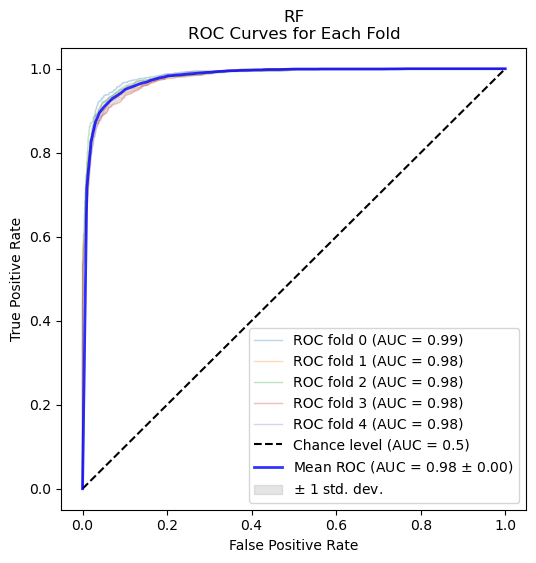

In [22]:
## Adapted from example in Scikit-Learn documentation - https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
# Initialize a StratifiedKFold object
cv = StratifiedKFold(n_splits=5)
y_train_binary = (y_train == 'Rotten').astype(int)

# Define the True Positive Rate (TPR), Area Under Curve (AUC) lists
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# Plotting
fig, ax = plt.subplots(figsize=(6, 6))

# Loop over each fold
for i, (train, test) in enumerate(cv.split(X_train_flat, y_train_binary)):

    # Compute ROC curve and ROC area for each fold using the `roc_curve` function
    fpr, tpr, _ = roc_curve(y_train_binary[test], y_train_pred_prob[test, 1])
    roc_auc = auc(fpr, tpr)

    # Interpolate the TPR
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)

    # Plot ROC for this fold
    ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f"ROC fold {i} (AUC = {roc_auc:.2f})")

ax.plot([0, 1], [0, 1], "k--", label="Chance level (AUC = 0.5)")

# Compute the mean ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot the mean ROC curve
ax.plot(mean_fpr, mean_tpr, color="b", label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc), lw=2, alpha=0.8)

# Plot the standard deviation around the mean ROC curve
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")

# Set plot properties
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], xlabel="False Positive Rate", ylabel="True Positive Rate", title="RF\nROC Curves for Each Fold")
ax.legend(loc="lower right")

# Show the plot
plt.show()

### Predict and evaluate performance on test set (out-of-sample)

#### Predict on test set

In [14]:
# Use the best model to make predictions on the test set
y_test_pred = grid_search.best_estimator_.predict(X_test_flat)

#### Confusion matrix

In [15]:
# Compute the confusion matrix
data = confusion_matrix(y_test, y_test_pred)
table = PrettyTable()
table.field_names = ["", "Predicted 0", "Predicted 1"]
table.add_row(["Actual 0", data[0][0], data[0][1]])
table.add_row(["Actual 1", data[1][0], data[1][1]])
print(f"Confusion Matrix (Random Forest, Test Data): \n {table}")

Confusion Matrix (Random Forest, Test Data): 
 +----------+-------------+-------------+
|          | Predicted 0 | Predicted 1 |
+----------+-------------+-------------+
| Actual 0 |     1181    |      75     |
| Actual 1 |      99     |     1112    |
+----------+-------------+-------------+


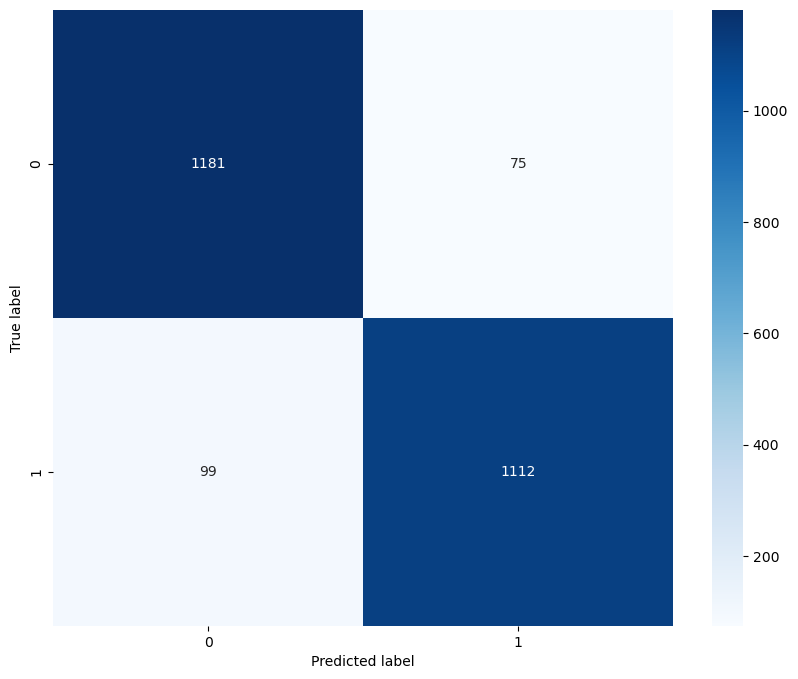

In [16]:
# Plot the confusion matrix using seaborn
plt.figure(figsize=(10,8))
sns.heatmap(data, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

#### Performance measures

In [17]:
# RF performance scores with cross validation
rf_scores_test = precision_recall_fscore_support(y_test, y_test_pred)

# Create performance measure table
tab2 = PrettyTable(["Performance Measure", "Label 0: fresh", "Label 1: rotten"])
measure_names = ["Precision", "Recall", "F1", "Support"]

# Add rows to table
tab2.add_row([measure_names[0]] + rf_scores_test[0].round(4).tolist())
tab2.add_row([measure_names[1]] + rf_scores_test[1].round(4).tolist())
tab2.add_row([measure_names[2]] + rf_scores_test[2].round(4).tolist())
tab2.add_row([measure_names[3]] + rf_scores_test[3].round(4).tolist())

# Print performance measure table and accuracy
print(f"Performance Measure Table (Random Forest, Test Data): \n {tab2}")
print(f"\nRandom Forest Accuracy Score: {accuracy_score(y_test, y_test_pred).round(4)}")

Performance Measure Table (Random Forest, Test Data): 
 +---------------------+----------------+-----------------+
| Performance Measure | Label 0: fresh | Label 1: rotten |
+---------------------+----------------+-----------------+
|      Precision      |     0.9227     |      0.9368     |
|        Recall       |     0.9403     |      0.9182     |
|          F1         |     0.9314     |      0.9274     |
|       Support       |      1256      |       1211      |
+---------------------+----------------+-----------------+

Random Forest Accuracy Score: 0.9295


----

### Complexity analysis - Baseline Model Comparison
- Baseline = all default RF hyperparameters
- Tuned model = optimal hyperparameters found from grid searches

#### Baseline (default RF params)

In [46]:
# Baseline model
baseline_model = RandomForestClassifier()

# Fit the baseline model
%time baseline_model.fit(X_train_flat, y_train)
print()

# Evaluate the baseline model
y_test_pred_base = baseline_model.predict(X_test_flat)
base_scores_test = precision_recall_fscore_support(y_test, y_test_pred_base)

# Create performance measure table for the baseline model
tab1 = PrettyTable(["Performance Measure", "Label 0: fresh", "Label 1: rotten"])
tab1.add_row([measure_names[0]] + base_scores_test[0].round(4).tolist())
tab1.add_row([measure_names[1]] + base_scores_test[1].round(4).tolist())
tab1.add_row([measure_names[2]] + base_scores_test[2].round(4).tolist())
tab1.add_row([measure_names[3]] + base_scores_test[3].round(4).tolist())

# Print performance measure table and accuracy for both models
print(f"Performance Measure Table (Baseline Model, Test Data): \n {tab1}")
print(f"\nBaseline Model Overall Accuracy Score: {accuracy_score(y_test, y_test_pred_base).round(4)}\n")

CPU times: user 2min 40s, sys: 960 ms, total: 2min 41s
Wall time: 2min 40s

Performance Measure Table (Baseline Model, Test Data): 
 +---------------------+----------------+-----------------+
| Performance Measure | Label 0: fresh | Label 1: rotten |
+---------------------+----------------+-----------------+
|      Precision      |     0.9235     |      0.9291     |
|        Recall       |     0.9323     |      0.9199     |
|          F1         |     0.9279     |      0.9245     |
|       Support       |      1256      |       1211      |
+---------------------+----------------+-----------------+

Baseline Model Overall Accuracy Score: 0.9262



#### Tuned (optimal RF params)

In [48]:
# Tuned model 
tuned_model = RandomForestClassifier(max_depth=30, max_features='log2', min_samples_split=2, n_estimators=800)

# Fit the complex model
%time tuned_model.fit(X_train_flat, y_train)

# Evaluate the complex model
y_test_pred_tuned = tuned_model.predict(X_test_flat)
tuned_scores_test = precision_recall_fscore_support(y_test, y_test_pred_tuned)

# Create performance measure table for the tuned model
tab2 = PrettyTable(["Performance Measure", "Label 0: fresh", "Label 1: rotten"])
tab2.add_row([measure_names[0]] + tuned_scores_test[0].round(4).tolist())
tab2.add_row([measure_names[1]] + tuned_scores_test[1].round(4).tolist())
tab2.add_row([measure_names[2]] + tuned_scores_test[2].round(4).tolist())
tab2.add_row([measure_names[3]] + tuned_scores_test[3].round(4).tolist())

print(f"\nPerformance Measure Table (Random Forest, Test Data): \n {tab2}")
print(f"\nTuned Random Forest Overall Accuracy Score: {accuracy_score(y_test, y_test_pred_tuned).round(4)}")

CPU times: user 1min 19s, sys: 720 ms, total: 1min 20s
Wall time: 1min 19s

Performance Measure Table (Random Forest, Test Data): 
 +---------------------+----------------+-----------------+
| Performance Measure | Label 0: fresh | Label 1: rotten |
+---------------------+----------------+-----------------+
|      Precision      |     0.9251     |      0.9409     |
|        Recall       |     0.9443     |      0.9207     |
|          F1         |     0.9346     |      0.9307     |
|       Support       |      1256      |       1211      |
+---------------------+----------------+-----------------+

Tuned Random Forest Overall Accuracy Score: 0.9327

